[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NU-MSE-LECTURES/465_Computational_Microscopy_2026/blob/dev/Week_04/code_examples/example_05_unet_segmentation.ipynb)

# Example 05: U-Net Architecture for Image Segmentation

## Overview
This notebook demonstrates the U-Net architecture, one of the most widely used deep learning models for image segmentation in microscopy and medical imaging. U-Net is ideal for:
1. **Semantic Segmentation** - Pixel-level classification
2. **Instance Segmentation** - Individual object identification
3. **Microscopy Analysis** - Cell/particle/defect segmentation
4. **Medical Imaging** - Organ and lesion segmentation

## Key Features of U-Net
- **Encoder-Decoder Structure**: Captures context while preserving spatial information
- **Skip Connections**: Concatenates features from downsampling path to upsampling path
- **Efficient Training**: Works well with limited training data
- **Pixel-wise Output**: Direct spatial correspondence between input and output

## Learning Objectives
- Understand U-Net architecture and its components
- Build U-Net from scratch using Keras
- Create synthetic segmentation datasets
- Train and evaluate segmentation models
- Visualize segmentation predictions
- Apply U-Net to microscopy-relevant tasks

## Prerequisites
- Week 4: CNN fundamentals (convolution, pooling, dense layers)
- Understanding of supervised learning
- Familiarity with image processing concepts

In [1]:
# Install required packages
import subprocess
import sys

try:
    import tensorflow
    print("TensorFlow already installed")
except ImportError:
    print("Installing TensorFlow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])
    print("TensorFlow installed successfully")

# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab.")
except ImportError:
    IN_COLAB = False
    print("Running locally.")

TensorFlow already installed
Running locally.


In [5]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from scipy import ndimage

# Image processing
from skimage import filters, morphology, measure
from scipy.ndimage import binary_fill_holes

# Metrics
from sklearn.metrics import jaccard_score, precision_score, recall_score

# Visualization
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("All libraries imported successfully!")

TensorFlow version: 2.20.0
Keras version: 3.12.0
All libraries imported successfully!


---

## Part 1: Create Synthetic Segmentation Dataset

We'll create a synthetic dataset of microscopy-like images with segmentation masks. The dataset contains circular and elliptical particles that need to be segmented from the background.

Creating synthetic segmentation dataset...
Training images shape: (80, 128, 128, 1)
Training masks shape: (80, 128, 128, 1)
Test images shape: (20, 128, 128, 1)
Test masks shape: (20, 128, 128, 1)


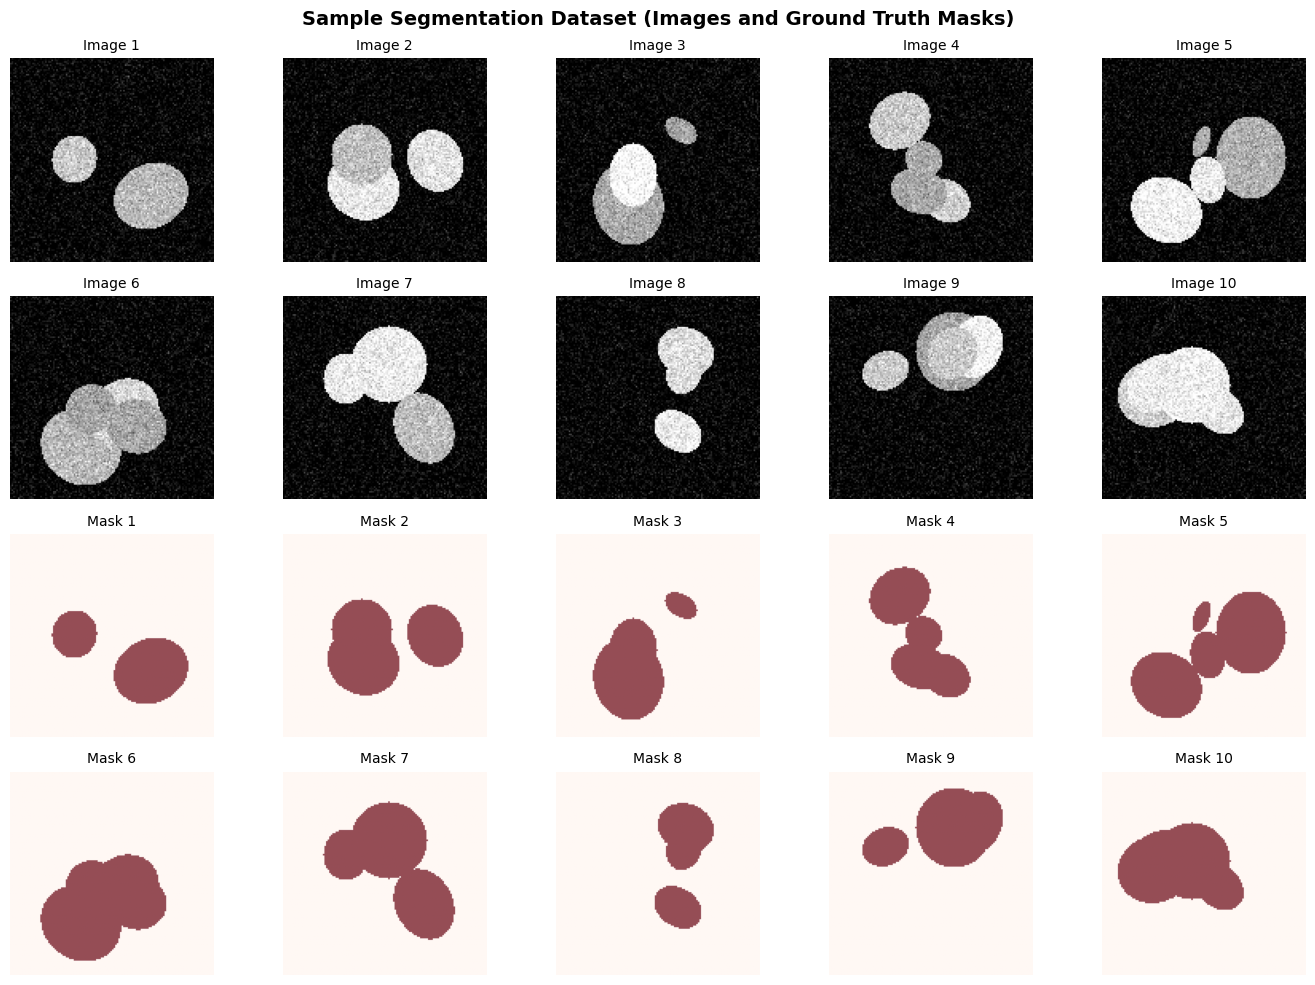

Dataset creation complete!


In [4]:
def create_synthetic_segmentation_dataset(n_samples=100, img_size=128, noise_level=0.1):
    """
    Generate synthetic segmentation dataset with particle-like objects.
    
    Args:
        n_samples: Number of image-mask pairs
        img_size: Size of images (square)
        noise_level: Amount of Gaussian noise to add
        
    Returns:
        images: Array of shape (n_samples, img_size, img_size, 1)
        masks: Array of shape (n_samples, img_size, img_size, 1) with binary segmentation
    """
    images = []
    masks = []
    
    for _ in range(n_samples):
        # Create blank image and mask
        img = np.zeros((img_size, img_size))
        mask = np.zeros((img_size, img_size))
        
        # Random number of particles (2-5 per image)
        n_particles = np.random.randint(2, 6)
        
        for _ in range(n_particles):
            # Random particle center
            cy = np.random.randint(img_size // 4, 3 * img_size // 4)
            cx = np.random.randint(img_size // 4, 3 * img_size // 4)
            
            # Random particle size
            radius = np.random.randint(10, 25)
            
            # Random ellipse axes for variety
            a = radius
            b = np.random.randint(radius - 5, radius + 5)
            angle = np.random.randint(0, 180)
            
            # Create elliptical mask
            y, x = np.ogrid[:img_size, :img_size]
            # Convert to radians and create ellipse equation
            angle_rad = np.radians(angle)
            cos_a = np.cos(angle_rad)
            sin_a = np.sin(angle_rad)
            
            xx = (x - cx) * cos_a + (y - cy) * sin_a
            yy = -(x - cx) * sin_a + (y - cy) * cos_a
            
            ellipse = (xx**2 / a**2 + yy**2 / b**2) <= 1
            
            # Add particle intensity to image
            particle_intensity = np.random.uniform(0.6, 1.0)
            img[ellipse] = particle_intensity
            mask[ellipse] = 1
        
        # Add Gaussian noise
        noise = np.random.normal(0, noise_level, img.shape)
        img = np.clip(img + noise, 0, 1)
        
        images.append(img)
        masks.append(mask)
    
    # Reshape to add channel dimension
    images = np.array(images).reshape(-1, img_size, img_size, 1)
    masks = np.array(masks).reshape(-1, img_size, img_size, 1)
    
    return images, masks

# Create dataset
print("Creating synthetic segmentation dataset...")
n_train = 80
n_test = 20

X_train, y_train = create_synthetic_segmentation_dataset(n_samples=n_train, img_size=128)
X_test, y_test = create_synthetic_segmentation_dataset(n_samples=n_test, img_size=128)

print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {y_test.shape}")

# Visualize sample images and masks
fig, axes = plt.subplots(4, 5, figsize=(14, 10))
fig.suptitle('Sample Segmentation Dataset (Images and Ground Truth Masks)', fontsize=14, fontweight='bold')

for idx in range(10):
    # Images
    ax_img = axes[0 + idx // 5, idx % 5]
    ax_img.imshow(X_train[idx].squeeze(), cmap='gray')
    ax_img.set_title(f'Image {idx+1}', fontsize=10)
    ax_img.axis('off')
    
    # Masks
    ax_mask = axes[2 + idx // 5, idx % 5]
    ax_mask.imshow(y_train[idx].squeeze(), cmap='Reds', alpha=0.7)
    ax_mask.set_title(f'Mask {idx+1}', fontsize=10)
    ax_mask.axis('off')

plt.tight_layout()
plt.show()

print("Dataset creation complete!")

---

## Part 2: Understanding U-Net Architecture

U-Net has a distinctive "U" shape with two main components:

### **Encoder (Left Side - Contracting Path)**
- Convolutional blocks with downsampling
- Extracts features at different scales
- Reduces spatial dimensions while increasing channels

### **Decoder (Right Side - Expanding Path)**
- Transposed convolution for upsampling
- Restores spatial dimensions
- Reduces number of channels

### **Skip Connections**
- Connect corresponding layers from encoder to decoder
- Preserve high-resolution features
- Enable better gradient flow during training

```
Input (128×128×1)
         ↓
    Conv → ReLU → BatchNorm
    Conv → ReLU → BatchNorm
         ↓ MaxPool
      (64×64×64)
         ↓ ... (repeat)
      (32×32×128)
         ↓ ... (repeat)
      (16×16×256) ← Bottleneck
         ↑
    Transposed Conv (Upsample)
    Concatenate with skip connection
      (32×32×128)
         ↑ ... (repeat)
      (64×64×64)
         ↑ ... (repeat)
    (128×128×1)
         ↓
    Output Mask
```

In [6]:
def build_unet(input_size=(128, 128, 1), num_filters_start=32):
    """
    Build U-Net architecture for image segmentation.
    
    Args:
        input_size: Input image dimensions (height, width, channels)
        num_filters_start: Number of filters in first conv layer
        
    Returns:
        Compiled Keras model
    """
    inputs = Input(input_size)
    
    # Encoder (Contracting Path)
    print("Building U-Net Encoder...")
    
    # Block 1
    conv1 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    # Block 3
    conv3 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    # Bottleneck
    print("Building U-Net Bottleneck...")
    conv4 = layers.Conv2D(num_filters_start*8, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(num_filters_start*8, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    
    # Decoder (Expanding Path)
    print("Building U-Net Decoder...")
    
    # Block 5 (Upsample)
    up5 = layers.UpSampling2D((2, 2))(conv4)
    up5 = layers.Concatenate()([up5, conv3])
    conv5 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    
    # Block 6 (Upsample)
    up6 = layers.UpSampling2D((2, 2))(conv5)
    up6 = layers.Concatenate()([up6, conv2])
    conv6 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    
    # Block 7 (Upsample)
    up7 = layers.UpSampling2D((2, 2))(conv6)
    up7 = layers.Concatenate()([up7, conv1])
    conv7 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    
    # Output layer - sigmoid for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='UNet')
    
    return model

# Build U-Net model
print("Creating U-Net model...")
unet_model = build_unet(input_size=(128, 128, 1), num_filters_start=32)

print("\nU-Net Architecture Summary:")
unet_model.summary()

# Count parameters
total_params = unet_model.count_params()
print(f"\nTotal U-Net Parameters: {total_params:,}")

Creating U-Net model...
Building U-Net Encoder...
Building U-Net Bottleneck...
Building U-Net Decoder...

U-Net Architecture Summary:


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 1,951,937 (7.45 MB)

 Trainable params: 1,949,121 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)


Total U-Net Parameters: 1,951,937


---

## Part 3: Define Loss Functions and Metrics for Segmentation

For segmentation tasks, we use different metrics than classification:
- **Dice Loss**: Measures overlap between predicted and ground truth masks
- **IoU/Jaccard**: Intersection over Union
- **Dice Coefficient**: F1-score for segmentation

In [7]:
def dice_loss(y_true, y_pred, smooth=1.0):
    """
    Dice Loss = 1 - Dice Coefficient
    Dice Coefficient = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef = (2.0 * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )
    return 1.0 - dice_coef

def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Dice Coefficient metric (for monitoring during training)"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )

def iou_metric(y_true, y_pred, smooth=1.0):
    """Intersection over Union (Jaccard Index)"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Compile U-Net model
print("Compiling U-Net model...")
unet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=dice_loss,  # Use Dice Loss for segmentation
    metrics=['binary_accuracy', dice_coefficient, iou_metric]
)

print("U-Net compiled successfully!")
print("Loss: Dice Loss")
print("Metrics: Binary Accuracy, Dice Coefficient, IoU")

Compiling U-Net model...
U-Net compiled successfully!
Loss: Dice Loss
Metrics: Binary Accuracy, Dice Coefficient, IoU


---

## Part 4: Train the U-Net Model

We'll train the U-Net on our synthetic segmentation dataset with:
- Early stopping to prevent overfitting
- Learning rate reduction for fine-tuning
- Training on 80 images, validation on 20 images

In [8]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Training U-Net model...")
print(f"Training samples: {len(X_train)}")
print(f"Validation split: 20%")

history = unet_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete!")

Training U-Net model...
Training samples: 80
Validation split: 20%
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - binary_accuracy: 0.9413 - dice_coefficient: 0.5869 - iou_metric: 0.4363 - loss: 0.4131 - val_binary_accuracy: 0.9904 - val_dice_coefficient: 0.2652 - val_iou_metric: 0.1529 - val_loss: 0.7348 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - binary_accuracy: 0.9941 - dice_coefficient: 0.7914 - iou_metric: 0.6561 - loss: 0.2086 - val_binary_accuracy: 0.9922 - val_dice_coefficient: 0.3124 - val_iou_metric: 0.1851 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - binary_accuracy: 0.9974 - dice_coefficient: 0.8371 - iou_metric: 0.7205 - loss: 0.1629 - val_binary_accuracy: 0.9637 - val_dice_coefficient: 0.3337 - val_iou_metric: 0.2003 - val_loss: 0.6663 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - binary_accuracy: 0.9984 - dice_coefficient: 0.8621 - iou_metric: 0.7583 - lo

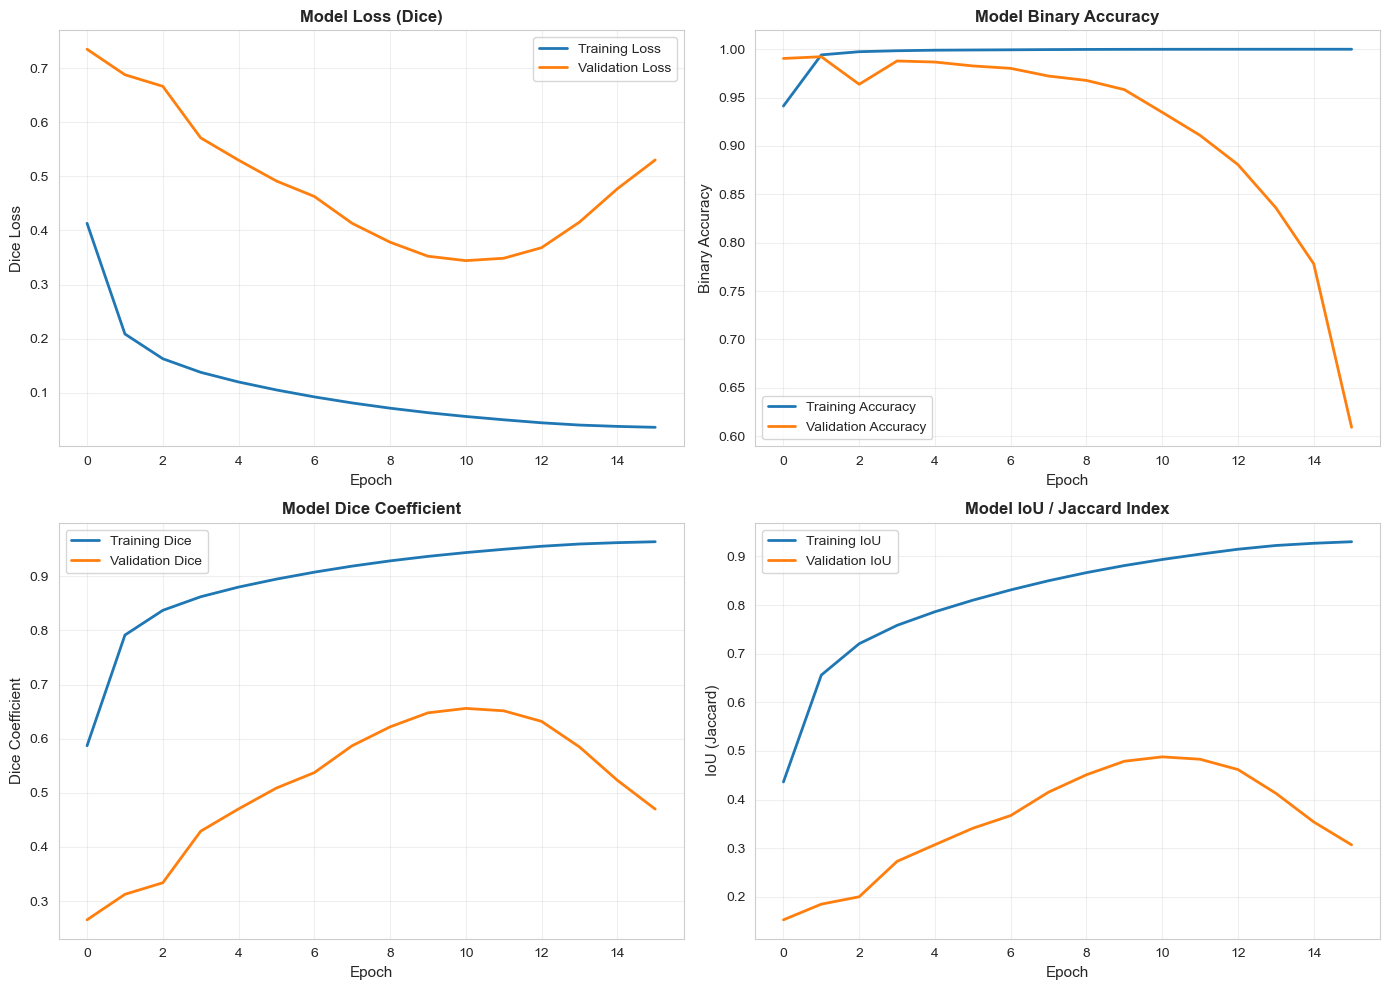


Training Summary:
Final Training Loss: 0.0362
Final Validation Loss: 0.5302
Final Training Dice: 0.9638
Final Validation Dice: 0.4698
Final Training IoU: 0.9302
Final Validation IoU: 0.3070
Total Epochs Trained: 16


In [9]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Dice Loss', fontsize=11)
axes[0, 0].set_title('Model Loss (Dice)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['binary_accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_binary_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Binary Accuracy', fontsize=11)
axes[0, 1].set_title('Model Binary Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Dice Coefficient
axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice', linewidth=2)
axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Dice Coefficient', fontsize=11)
axes[1, 0].set_title('Model Dice Coefficient', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# IoU
axes[1, 1].plot(history.history['iou_metric'], label='Training IoU', linewidth=2)
axes[1, 1].plot(history.history['val_iou_metric'], label='Validation IoU', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('IoU (Jaccard)', fontsize=11)
axes[1, 1].set_title('Model IoU / Jaccard Index', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print("\nTraining Summary:")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training Dice: {history.history['dice_coefficient'][-1]:.4f}")
print(f"Final Validation Dice: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"Final Training IoU: {history.history['iou_metric'][-1]:.4f}")
print(f"Final Validation IoU: {history.history['val_iou_metric'][-1]:.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")

---

## Part 5: Evaluate Segmentation Performance on Test Set

We'll evaluate the U-Net on test data and compute segmentation metrics.

In [10]:
# Evaluate on test set
print("Evaluating U-Net on test set...")
test_results = unet_model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"Test Loss (Dice): {test_results[0]:.4f}")
print(f"Test Binary Accuracy: {test_results[1]:.4f}")
print(f"Test Dice Coefficient: {test_results[2]:.4f}")
print(f"Test IoU: {test_results[3]:.4f}")

# Make predictions on test set
y_pred = unet_model.predict(X_test, verbose=0)

# Apply threshold to get binary masks (threshold = 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.float32)

# Calculate metrics for each test sample
dice_scores = []
iou_scores = []

for i in range(len(X_test)):
    # Flatten for metric calculation
    y_true_flat = y_test[i].flatten()
    y_pred_flat = y_pred_binary[i].flatten()
    
    # Dice coefficient
    dice = (2 * np.sum(y_true_flat * y_pred_flat)) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-7)
    dice_scores.append(dice)
    
    # IoU
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    iou = intersection / (union + 1e-7)
    iou_scores.append(iou)

print(f"\nPer-Sample Metrics:")
print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
print(f"Mean IoU: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")
print(f"Min IoU: {np.min(iou_scores):.4f}")
print(f"Max IoU: {np.max(iou_scores):.4f}")

Evaluating U-Net on test set...

Test Set Performance:
Test Loss (Dice): 0.3273
Test Binary Accuracy: 0.9331
Test Dice Coefficient: 0.6727
Test IoU: 0.5068

Per-Sample Metrics:
Mean Dice Coefficient: 0.8255 ± 0.0363
Mean IoU: 0.7044 ± 0.0520
Min IoU: 0.6032
Max IoU: 0.8017


---

## Part 6: Visualize Segmentation Results

Let's visualize the model's segmentation predictions on test images compared to ground truth masks.

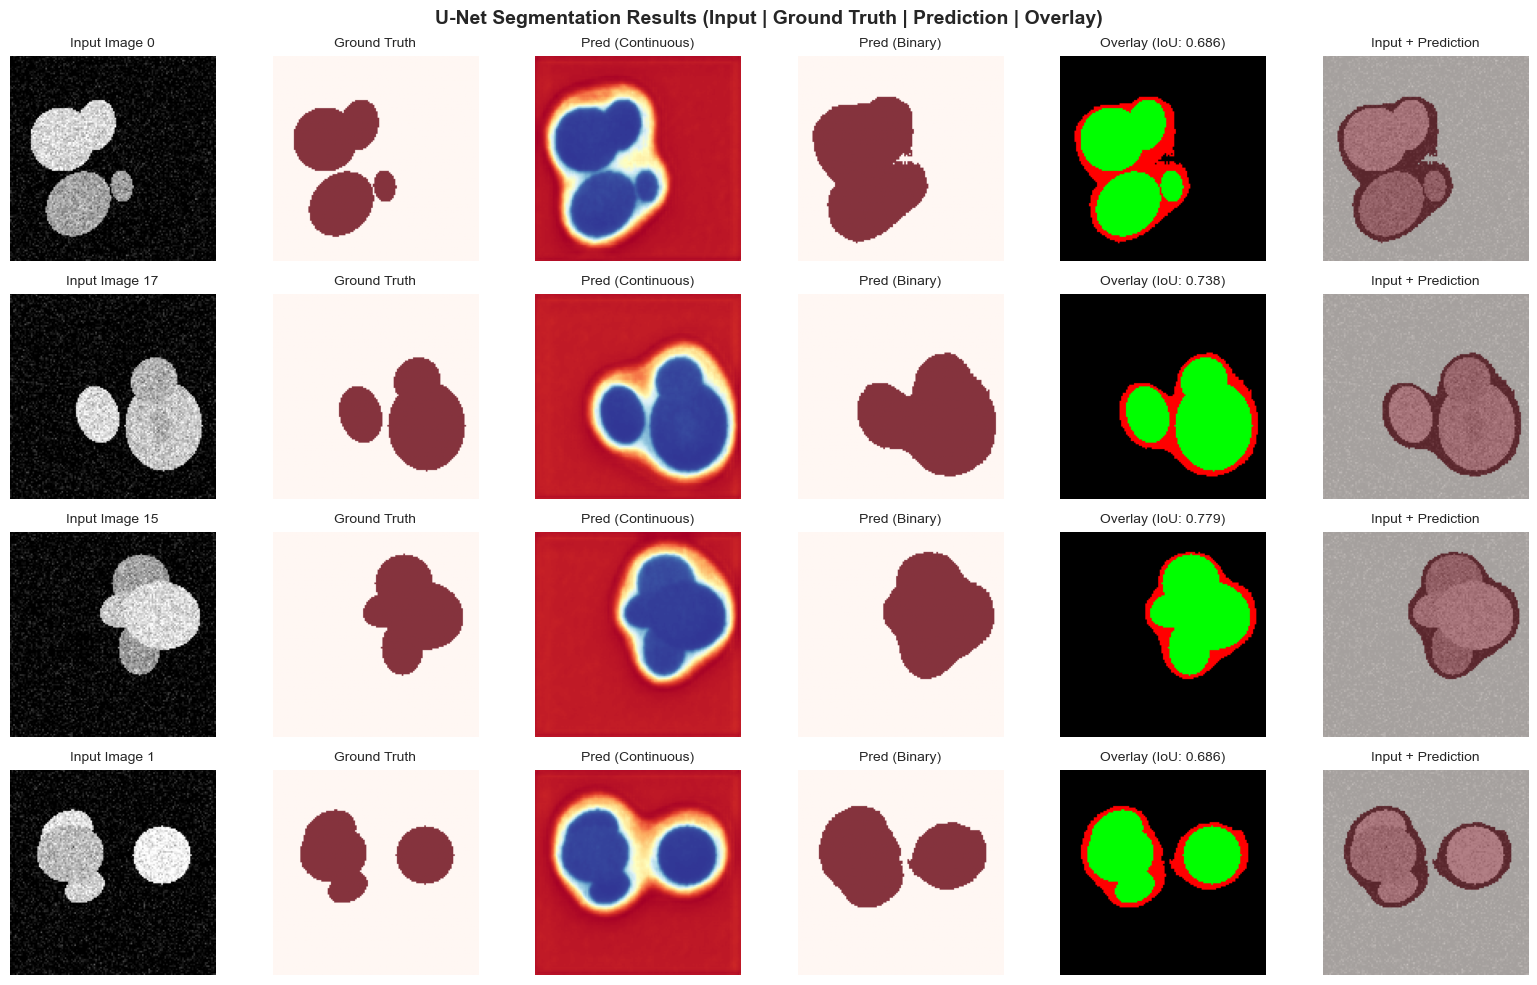

Segmentation visualization complete!


In [11]:
# Visualize segmentation results
fig, axes = plt.subplots(4, 6, figsize=(16, 10))
fig.suptitle('U-Net Segmentation Results (Input | Ground Truth | Prediction | Overlay)', 
             fontsize=14, fontweight='bold')

sample_indices = np.random.choice(len(X_test), size=4, replace=False)

for row, sample_idx in enumerate(sample_indices):
    # Input image
    ax = axes[row, 0]
    ax.imshow(X_test[sample_idx].squeeze(), cmap='gray')
    ax.set_title(f'Input Image {sample_idx}', fontsize=10)
    ax.axis('off')
    
    # Ground truth mask
    ax = axes[row, 1]
    ax.imshow(y_test[sample_idx].squeeze(), cmap='Reds', alpha=0.8)
    ax.set_title('Ground Truth', fontsize=10)
    ax.axis('off')
    
    # Predicted mask (continuous)
    ax = axes[row, 2]
    ax.imshow(y_pred[sample_idx].squeeze(), cmap='RdYlBu')
    ax.set_title('Pred (Continuous)', fontsize=10)
    ax.axis('off')
    
    # Predicted mask (binary)
    ax = axes[row, 3]
    ax.imshow(y_pred_binary[sample_idx].squeeze(), cmap='Reds', alpha=0.8)
    ax.set_title('Pred (Binary)', fontsize=10)
    ax.axis('off')
    
    # Overlay: True positive (green), False positive (red), False negative (blue)
    ax = axes[row, 4]
    tp = y_test[sample_idx].squeeze() * y_pred_binary[sample_idx].squeeze()
    fp = (1 - y_test[sample_idx].squeeze()) * y_pred_binary[sample_idx].squeeze()
    fn = y_test[sample_idx].squeeze() * (1 - y_pred_binary[sample_idx].squeeze())
    
    overlay = np.zeros((*y_test[sample_idx].shape[:-1], 3))
    overlay[..., 0] = fp  # False positives in red
    overlay[..., 1] = tp  # True positives in green
    overlay[..., 2] = fn  # False negatives in blue
    
    ax.imshow(overlay)
    ax.set_title(f'Overlay (IoU: {iou_scores[sample_idx]:.3f})', fontsize=10)
    ax.axis('off')
    
    # Input with prediction overlay
    ax = axes[row, 5]
    ax.imshow(X_test[sample_idx].squeeze(), cmap='gray', alpha=0.7)
    ax.imshow(y_pred_binary[sample_idx].squeeze(), cmap='Reds', alpha=0.5)
    ax.set_title('Input + Prediction', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Segmentation visualization complete!")

---

## Part 7: Analyze U-Net Feature Maps

Let's visualize intermediate feature maps to understand what the U-Net learns at different depths.

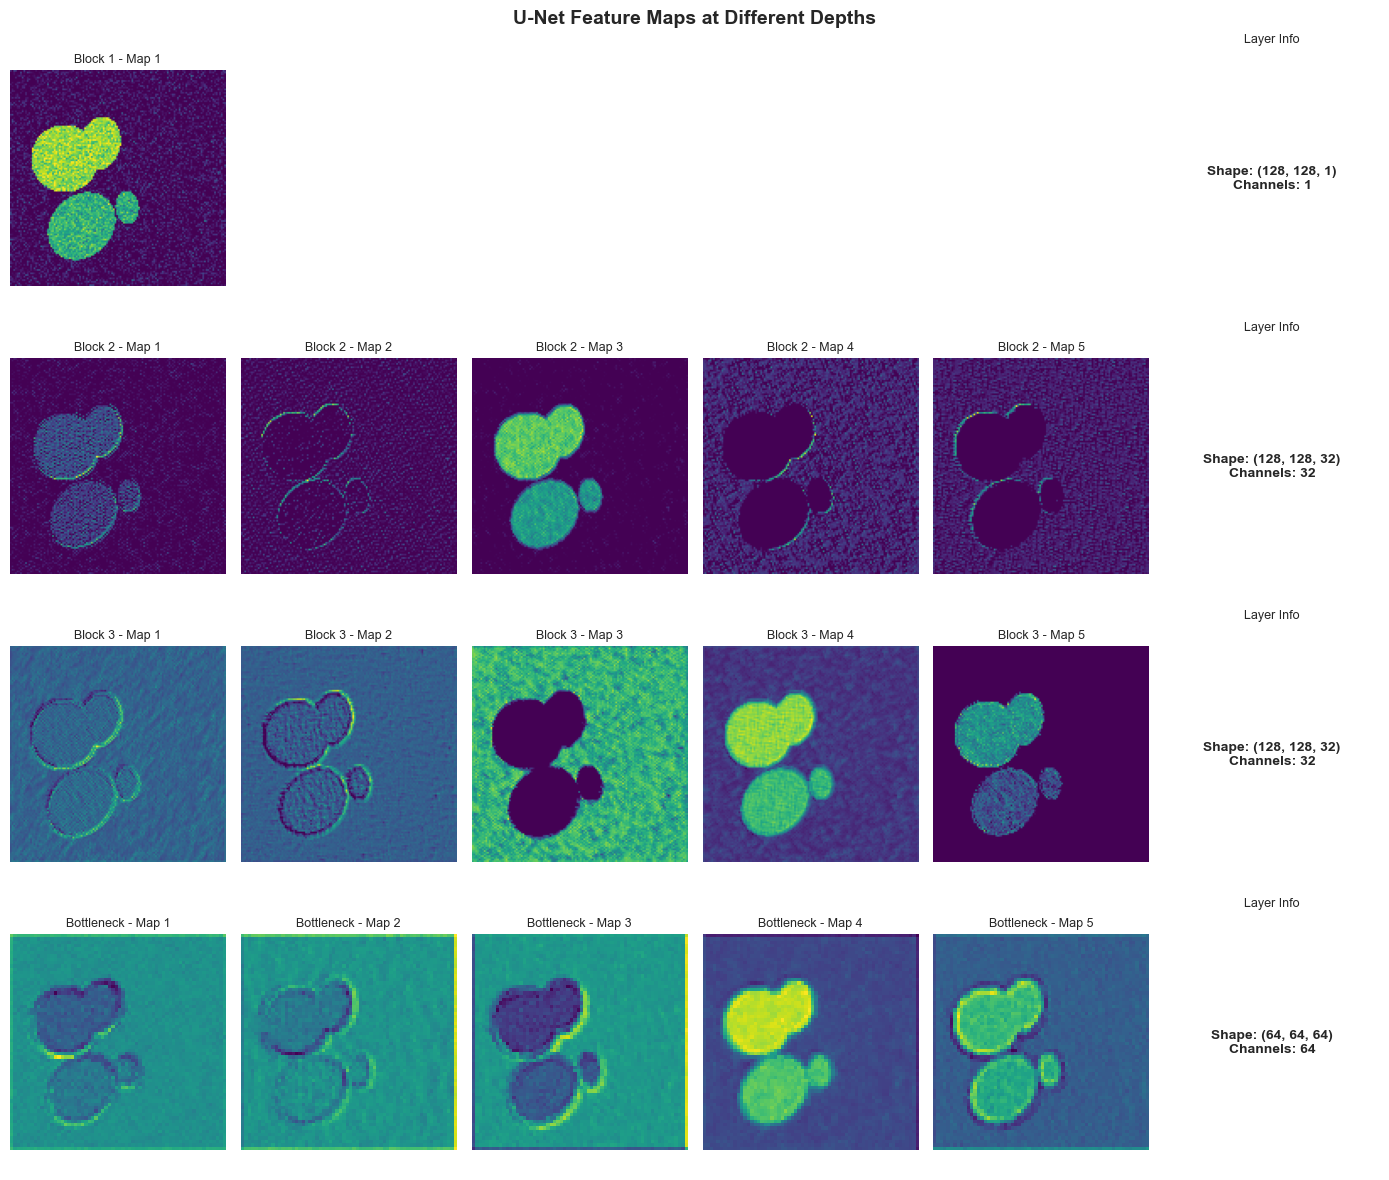

Feature map visualization complete!


In [12]:
# Extract intermediate feature maps from different layers
sample_image = X_test[0:1]

# Get layer indices for visualization (encoder layers)
# Layers 0, 3, 6 correspond to first convolution outputs in each encoder block
layer_indices = [0, 3, 6, 9]  # Different depths in encoder
layer_names = ['Block 1', 'Block 2', 'Block 3', 'Bottleneck']

fig, axes = plt.subplots(4, 6, figsize=(14, 12))
fig.suptitle('U-Net Feature Maps at Different Depths', fontsize=14, fontweight='bold')

for row, (layer_idx, layer_name) in enumerate(zip(layer_indices, layer_names)):
    # Create intermediate model
    intermediate_model = keras.Model(
        inputs=unet_model.input,
        outputs=unet_model.layers[layer_idx].output
    )
    
    # Get feature maps
    feature_maps = intermediate_model.predict(sample_image, verbose=0)
    
    # Plot first 5 feature maps
    for col in range(6):
        ax = axes[row, col]
        
        if col < min(5, feature_maps.shape[-1]):
            # Normalize feature map for visualization
            fmap = feature_maps[0, :, :, col]
            fmap_normalized = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-7)
            
            ax.imshow(fmap_normalized, cmap='viridis')
            ax.set_title(f'{layer_name} - Map {col+1}', fontsize=9)
        elif col == 5:
            # Last subplot shows shape info
            ax.text(0.5, 0.5, f'Shape: {feature_maps.shape[1:]}\n' + 
                            f'Channels: {feature_maps.shape[-1]}',
                   ha='center', va='center', fontsize=10, fontweight='bold')
            ax.set_title('Layer Info', fontsize=9)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

print("Feature map visualization complete!")

---

## Part 8: Key U-Net Concepts and Applications

### Advantages of U-Net:
1. **Encoder-Decoder with Skip Connections**: Preserves fine details while capturing context
2. **Data Efficient**: Works well with limited labeled data (important for microscopy!)
3. **End-to-End Learning**: Direct pixel-to-pixel prediction
4. **Flexible**: Can be adapted to different image sizes and tasks

### Microscopy Applications:
- **Cell Segmentation**: Identify individual cells in microscopy images
- **Particle Detection**: Locate and segment nanoparticles in TEM/SEM images
- **Defect Detection**: Identify crystallographic defects in materials
- **Phase Segmentation**: Segment different phases in multi-phase materials

### Variants of U-Net:
- **V-Net**: 3D segmentation (for volumetric data)
- **3D U-Net**: Extension for 3D medical/microscopy data
- **Attention U-Net**: Incorporates attention mechanisms
- **Dense U-Net**: Uses dense connections for improved feature propagation
- **U-Net++**: Nested skip connections for multi-scale feature fusion

In [13]:
# Compare U-Net with simpler baseline models
print("\n" + "="*60)
print("ARCHITECTURE COMPARISON")
print("="*60 + "\n")

# Simple FCN (Fully Convolutional Network)
def build_simple_fcn(input_size=(128, 128, 1)):
    """Simple FCN without skip connections"""
    inputs = Input(input_size)
    
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    # Upsampling without skip connections
    up1 = layers.UpSampling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(up1)
    
    up2 = layers.UpSampling2D((2, 2))(conv3)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up2)
    
    return models.Model(inputs=inputs, outputs=outputs, name='SimpleFCN')

# Create models
simple_fcn = build_simple_fcn()

architectures = {
    'Simple FCN (No Skip)': simple_fcn,
    'U-Net (With Skip)': unet_model
}

print("Model Architecture Comparison:")
print(f"{'Model':<25} {'Parameters':<15} {'Trainable Params':<20}")
print("-" * 60)

for name, model in architectures.items():
    total_params = model.count_params()
    print(f"{name:<25} {total_params:<15,} {total_params:<20,}")

print("\n✓ U-Net notebook completed successfully!")
print("\nKey Takeaways:")
print("1. U-Net is specifically designed for segmentation tasks")
print("2. Skip connections preserve spatial information from encoder")
print("3. Works better than simple FCNs with limited training data")
print("4. Easily adaptable to different image sizes and domains")
print("5. Perfect for microscopy image analysis applications")


ARCHITECTURE COMPARISON

Model Architecture Comparison:
Model                     Parameters      Trainable Params    
------------------------------------------------------------
Simple FCN (No Skip)      37,313          37,313              
U-Net (With Skip)         1,951,937       1,951,937           

✓ U-Net notebook completed successfully!

Key Takeaways:
1. U-Net is specifically designed for segmentation tasks
2. Skip connections preserve spatial information from encoder
3. Works better than simple FCNs with limited training data
4. Easily adaptable to different image sizes and domains
5. Perfect for microscopy image analysis applications
